In [11]:
# Imports
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# Load data and process conditions
df = pd.read_csv("../results/basic_frame_all_results.csv")

# Compute allocation proportions
df['partner_alloc'] = df['alloc1'] / (df['alloc0'] + df['alloc1'])
df['self_alloc'] = df['alloc0'] / (df['alloc0'] + df['alloc1'])

# Extract experimental conditions - now including cot
df['framing'] = df['experiment_id'].str.extract('basic_(give|take|divide)')[0]
df['cot'] = df['experiment_id'].str.contains('_cot')

# Quick look at the data
print("Dataset shape:", df.shape)
print("\nSample allocations:")
print(df[['model', 'self_alloc', 'partner_alloc', 'framing', 'cot']].head())

Dataset shape: (972, 14)

Sample allocations:
                        model  self_alloc  partner_alloc framing   cot
0     claude-3-haiku-20240307       0.800          0.200    give  True
1     claude-3-haiku-20240307       0.000          1.000    take  True
2     claude-3-haiku-20240307       0.500          0.500  divide  True
3  claude-3-5-sonnet-20241022       0.500          0.500    give  True
4  claude-3-5-sonnet-20241022       0.000          1.000    take  True


In [13]:
# Helper function for statistical tests
def analyze_groups(group1, group2, label1, label2):
    """
    Performs statistical analysis comparing two groups of allocation data.
    
    Args:
        group1, group2: Arrays of allocation proportions
        label1, label2: Names of the groups being compared
    """
    # Mann-Whitney U test
    stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    
    # Effect size (Cohen's d)
    d = (np.mean(group1) - np.mean(group2)) / np.sqrt(
        ((len(group1) - 1) * np.var(group1) + 
         (len(group2) - 1) * np.var(group2)) / 
        (len(group1) + len(group2) - 2)
    )
    
    # Interpret effect size
    if abs(d) < 0.2:
        effect = "negligible"
    elif abs(d) < 0.5:
        effect = "small"
    elif abs(d) < 0.8:
        effect = "medium"
    else:
        effect = "large"
    
    print(f"\n{label1} (n={len(group1)}) vs {label2} (n={len(group2)}):")
    print(f"  Partner allocation: {np.mean(group1)*100:.1f}% vs {np.mean(group2)*100:.1f}%")
    print(f"  Difference: {(np.mean(group1) - np.mean(group2))*100:.1f}% points")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Effect size: {abs(d):.3f} ({effect})")

=== Model Comparisons ===

claude-3-haiku-20240307 (n=258) vs claude-3-5-sonnet-20241022 (n=258):
  Partner allocation: 58.5% vs 65.8%
  Difference: -7.2% points
  p-value: nan
  Effect size: 0.312 (small)

claude-3-haiku-20240307 (n=258) vs claude-3-5-haiku-20241022 (n=258):
  Partner allocation: 58.5% vs 62.3%
  Difference: -3.8% points
  p-value: nan
  Effect size: 0.164 (negligible)

claude-3-haiku-20240307 (n=258) vs claude-3-opus-20240229 (n=198):
  Partner allocation: 58.5% vs 63.0%
  Difference: -4.4% points
  p-value: nan
  Effect size: 0.201 (small)

claude-3-5-sonnet-20241022 (n=258) vs claude-3-5-haiku-20241022 (n=258):
  Partner allocation: 65.8% vs 62.3%
  Difference: 3.5% points
  p-value: 0.027745
  Effect size: 0.145 (negligible)

claude-3-5-sonnet-20241022 (n=258) vs claude-3-opus-20240229 (n=198):
  Partner allocation: 65.8% vs 63.0%
  Difference: 2.8% points
  p-value: nan
  Effect size: 0.120 (negligible)

claude-3-5-haiku-20241022 (n=258) vs claude-3-opus-20240229

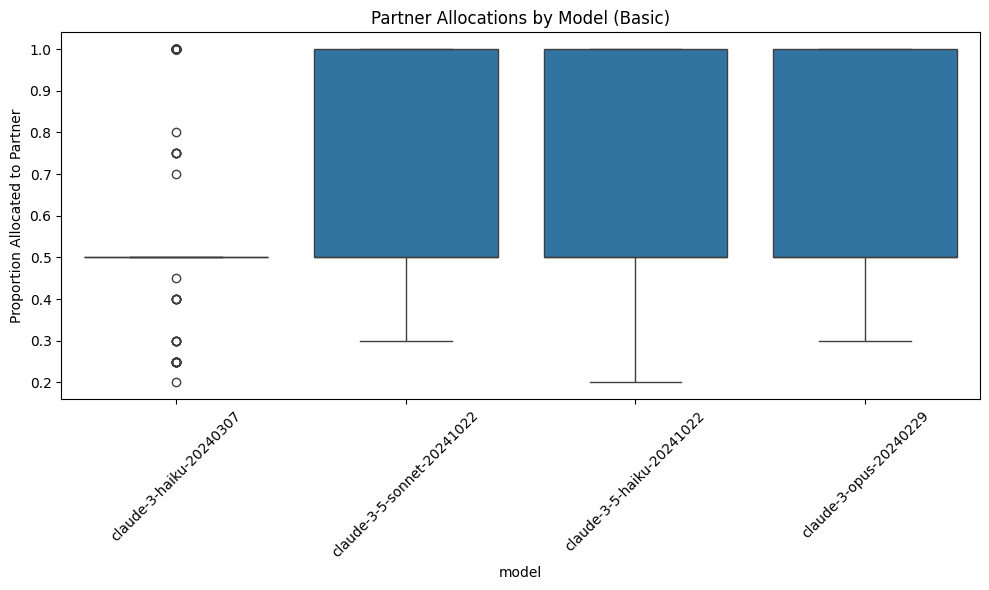

In [14]:
# Analyze model differences
print("=== Model Comparisons ===")
models = df['model'].unique()

for i, model1 in enumerate(models):
    for model2 in models[i+1:]:
        group1 = df[df['model'] == model1]['partner_alloc']
        group2 = df[df['model'] == model2]['partner_alloc']
        analyze_groups(group1, group2, model1, model2)

# Visualize model differences
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='model', y='partner_alloc')
plt.title('Partner Allocations by Model (Basic)')
plt.ylabel('Proportion Allocated to Partner')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== CoT vs NoCoT ===

CoT (n=492) vs NoCoT (n=480):
  Partner allocation: 62.2% vs 62.6%
  Difference: -0.4% points
  p-value: nan
  Effect size: 0.016 (negligible)


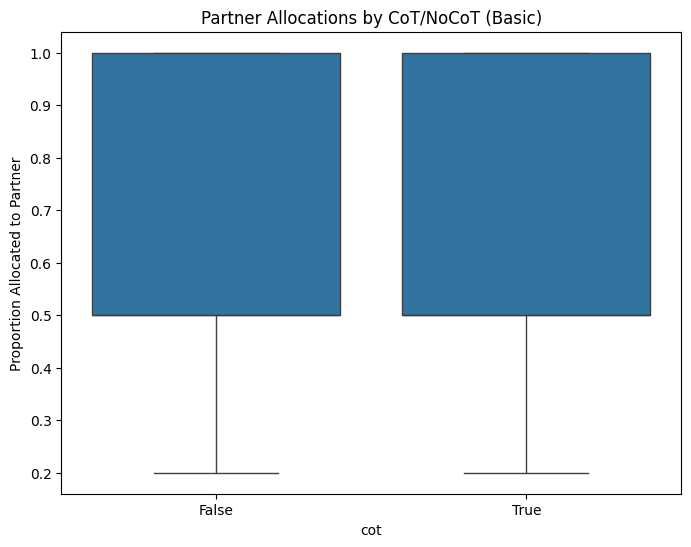

In [15]:
# Analyze cot differences
print("=== CoT vs NoCoT ===")
cot_group = df[df['cot']]['partner_alloc']
nocot_group = df[~df['cot']]['partner_alloc']
analyze_groups(cot_group, nocot_group, 'CoT', 'NoCoT')

# Visualize cot differences
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='cot', y='partner_alloc')
plt.title('Partner Allocations by CoT/NoCoT (Basic)')
plt.ylabel('Proportion Allocated to Partner')
plt.show()

=== Framing Comparisons ===

give (n=324) vs take (n=324):
  Partner allocation: 47.5% vs 93.8%
  Difference: -46.3% points
  p-value: nan
  Effect size: 3.936 (large)

give (n=324) vs divide (n=324):
  Partner allocation: 47.5% vs 48.6%
  Difference: -1.0% points
  p-value: nan
  Effect size: 0.196 (negligible)

take (n=324) vs divide (n=324):
  Partner allocation: 93.8% vs 48.6%
  Difference: 45.2% points
  p-value: nan
  Effect size: 4.018 (large)


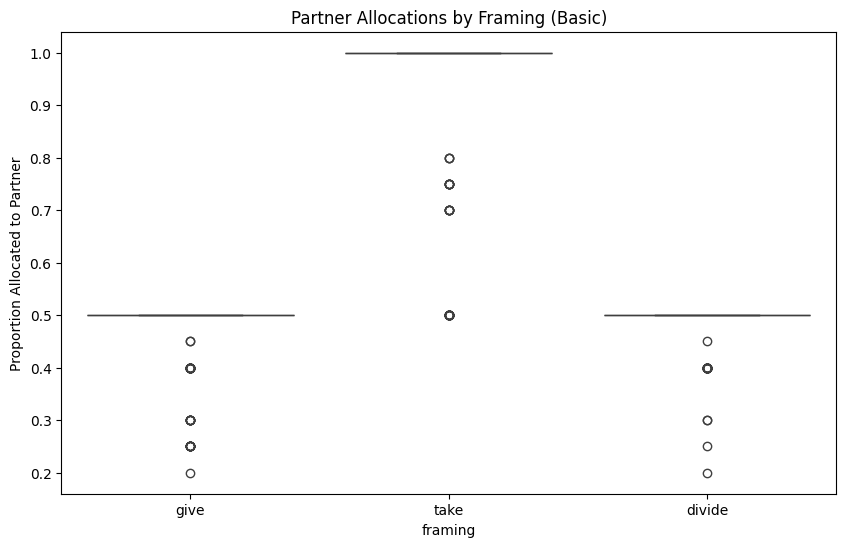

In [16]:
# Analyze framing differences
print("=== Framing Comparisons ===")
framings = df['framing'].unique()

for i, frame1 in enumerate(framings):
    for frame2 in framings[i+1:]:
        group1 = df[df['framing'] == frame1]['partner_alloc']
        group2 = df[df['framing'] == frame2]['partner_alloc']
        analyze_groups(group1, group2, frame1, frame2)

# Visualize framing differences
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='framing', y='partner_alloc')
plt.title('Partner Allocations by Framing (Basic)')
plt.ylabel('Proportion Allocated to Partner')
plt.show()

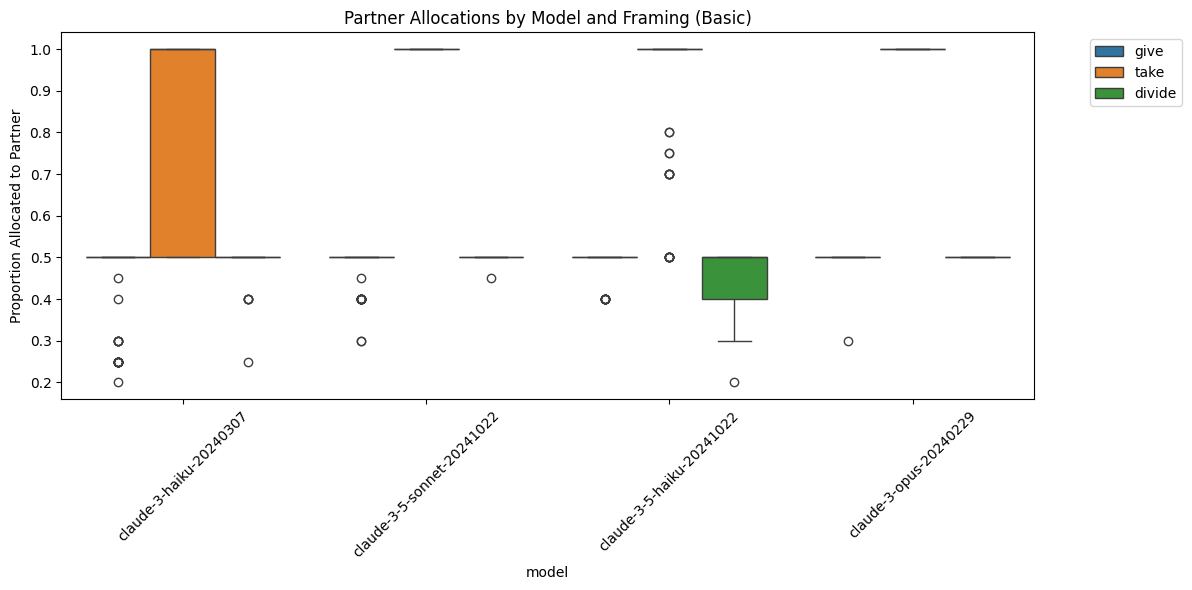

In [17]:
# Look at model-framing interactions
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='model', y='partner_alloc', hue='framing')
plt.title('Partner Allocations by Model and Framing (Basic)')
plt.ylabel('Proportion Allocated to Partner')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

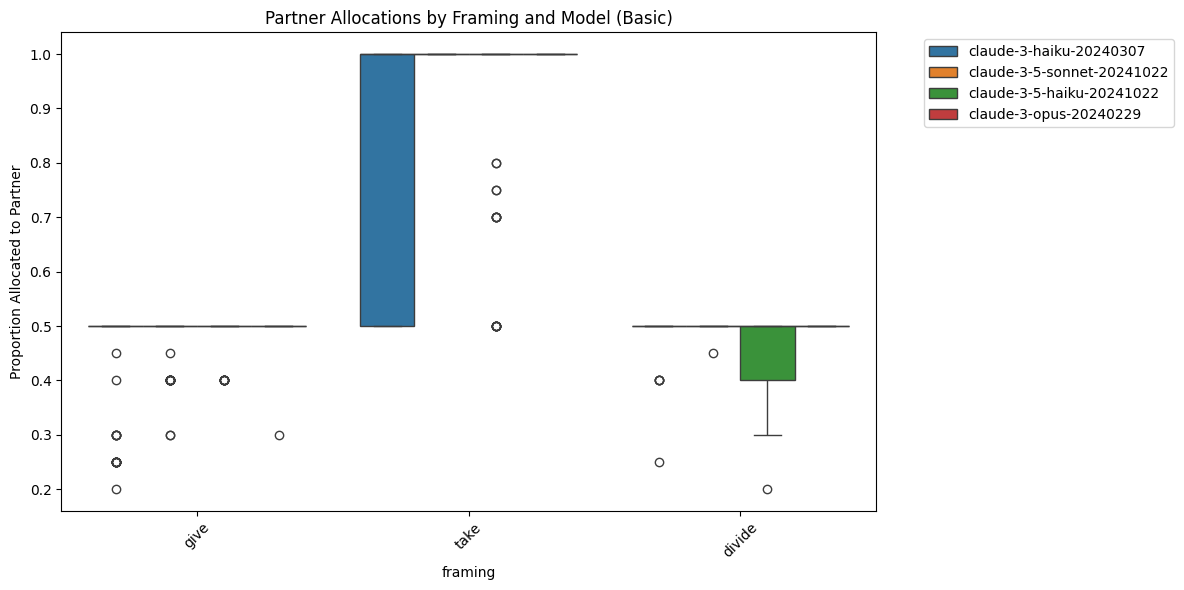

In [39]:
# Look at framing-model interactions
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='framing', y='partner_alloc', hue='model')
plt.title('Partner Allocations by Framing and Model (Basic)')
plt.ylabel('Proportion Allocated to Partner')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/Users/adelin/Documents/Projects/UK AISI Research Sprint/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/adelin/Documents/Projects/UK AISI Research Sprint/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1200x800 with 0 Axes>

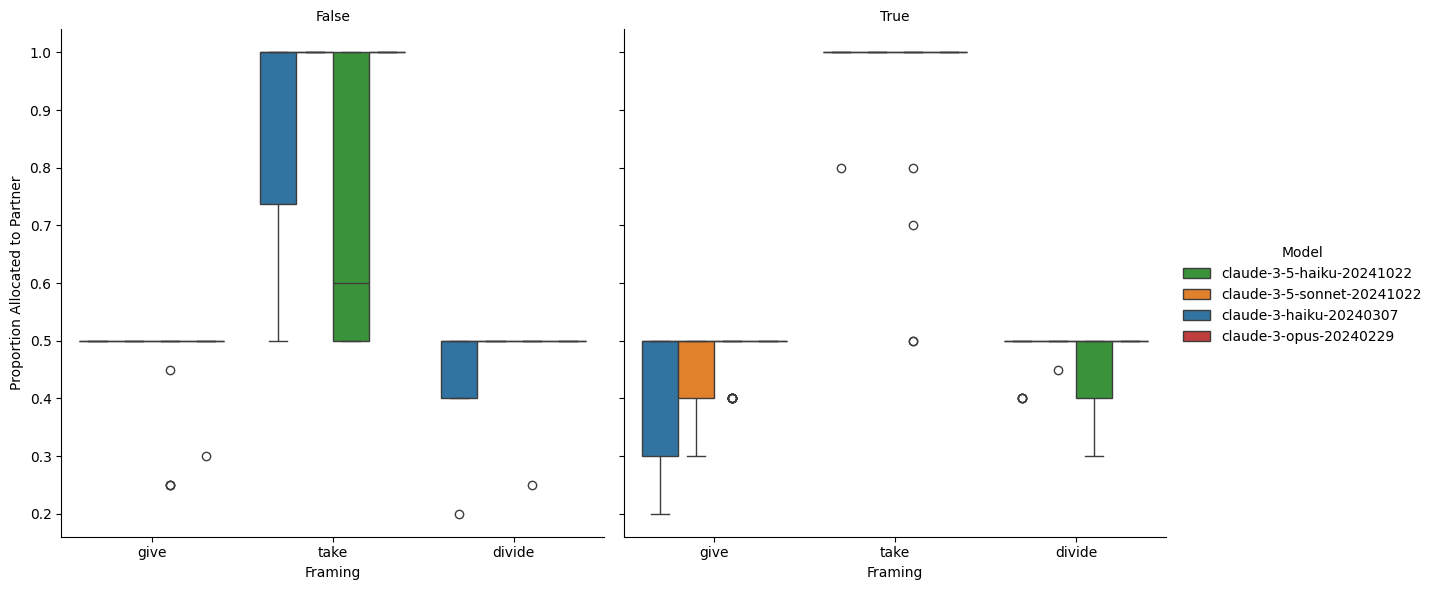

In [41]:
# Plotting code for boxplots with x axis showing framing, colors showing model, and facet panels showing chain of thought
plt.figure(figsize=(12, 8))
g = sns.FacetGrid(df, col="cot", height=6)
g.map(sns.boxplot, "framing", "partner_alloc", "model", palette="tab10")
g.set_axis_labels("Framing", "Proportion Allocated to Partner")
g.set_titles(col_template="{col_name}")
g.add_legend(title="Model")
plt.show()



In [19]:
# Create summary statistics including cot groups
summary_stats = df.groupby(['cot', 'framing', 'model'])['partner_alloc'].agg([
    'count',
    'mean',
    'std'
]).reset_index()

# Add 95% confidence intervals
summary_stats['ci'] = 1.96 * summary_stats['std'] / np.sqrt(summary_stats['count'])

# Create a single dataframe with all subgroup conditions
all_stats = summary_stats.sort_values(['cot', 'framing', 'model'])

# Format for printing
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(all_stats.to_string(index=False))

# Save to csv
all_stats.to_csv('../results/basic_dictator_all_stats.csv', index=False)

def get_subgroup_allocs(data, cot, frame, model):
    mask = (
        (data['cot'] == cot) &
        (data['framing'] == frame) & 
        (data['model'] == model)
    )
    return data[mask]['partner_alloc']

# Compare all subgroup pairs
print("\n=== Most Extreme Differences ===")
data = df
    
cots = [True, False]
frames = data['framing'].unique()
models = data['model'].unique()

# Find most extreme differences
comparisons = []
for is_cot in cots:
    for f1 in frames:
        for m1 in models:
            group1 = get_subgroup_allocs(data, is_cot, f1, m1)
            if len(group1) == 0:
                continue
                
            for is_cot2 in cots:
                for f2 in frames:
                    for m2 in models:
                        if is_cot == is_cot2 and f1 == f2 and m1 == m2:
                            continue
                        
                        group2 = get_subgroup_allocs(data, is_cot2, f2, m2)
                        if len(group2) == 0:
                            continue
                        
                        diff = np.mean(group1) - np.mean(group2)
                        comparisons.append({
                            'group1': f"{'cot' if is_cot else 'nocot'}-{f1}-{m1}",
                            'group2': f"{'cot' if is_cot2 else 'nocot'}-{f2}-{m2}",
                            'diff': diff,
                            'mean1': np.mean(group1),
                            'mean2': np.mean(group2)
                        })

# Sort by absolute difference and show top 5
comparisons.sort(key=lambda x: abs(x['diff']), reverse=True)
print("\nLargest differences between subgroups:")
for i, comp in enumerate(comparisons[:5], 1):
    print(f"\n{i}. {comp['group1']} vs {comp['group2']}")
    print(f"   {comp['mean1']*100:.1f}% vs {comp['mean2']*100:.1f}%")
    print(f"   Difference: {comp['diff']*100:.1f}% points")

  cot framing                      model  count  mean   std    ci
False  divide  claude-3-5-haiku-20241022     40 0.450 0.064 0.020
False  divide claude-3-5-sonnet-20241022     40 0.500 0.000 0.000
False  divide    claude-3-haiku-20240307     40 0.494 0.040 0.012
False  divide     claude-3-opus-20240229     40 0.500 0.000 0.000
False    give  claude-3-5-haiku-20241022     40 0.500 0.000 0.000
False    give claude-3-5-sonnet-20241022     40 0.500 0.000 0.000
False    give    claude-3-haiku-20240307     40 0.480 0.067 0.021
False    give     claude-3-opus-20240229     40 0.495 0.032 0.010
False    take  claude-3-5-haiku-20241022     40 0.878 0.191 0.059
False    take claude-3-5-sonnet-20241022     40 1.000 0.000 0.000
False    take    claude-3-haiku-20240307     40 0.711 0.230 0.071
False    take     claude-3-opus-20240229     40 1.000 0.000 0.000
 True  divide  claude-3-5-haiku-20241022     46 0.459 0.058 0.017
 True  divide claude-3-5-sonnet-20241022     46 0.499 0.007 0.002
 True  div

/var/folders/cy/v0c3q2h12ns8glbx7yr_2cqm0000gs/T/ipykernel_31118/1909845118.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_city_filtered['partner_alloc'] = df_city_filtered['alloc1'] / (df_city_filtered['alloc0'] + df_city_filtered['alloc1'])
/var/folders/cy/v0c3q2h12ns8glbx7yr_2cqm0000gs/T/ipykernel_31118/1909845118.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_city_filtered['self_alloc'] = df_city_filtered['alloc0'] / (df_city_filtered['alloc0'] + df_city_filtered['alloc1'])
/var/folder

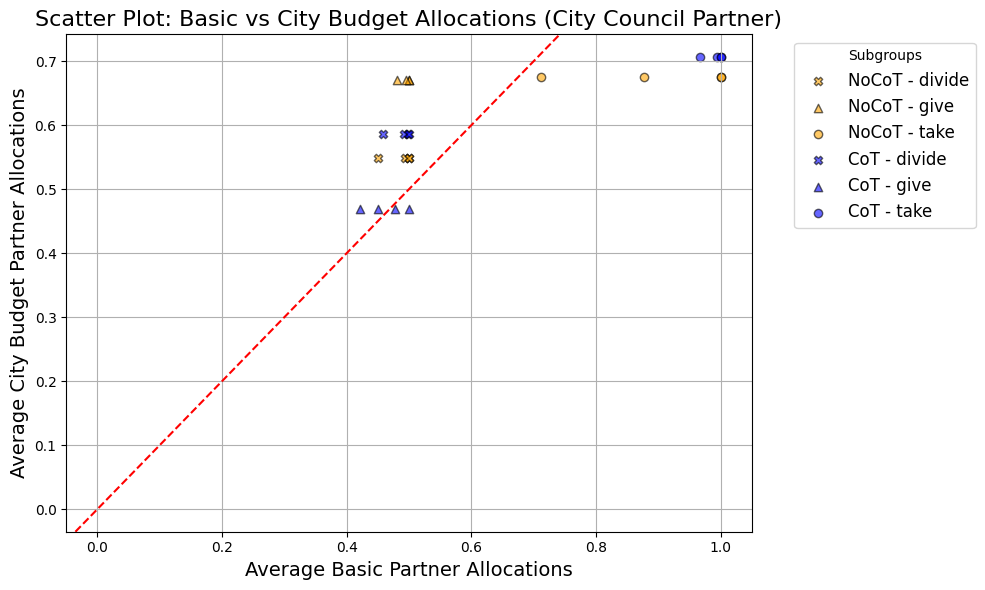

In [42]:
# Load the basic allocations data
df_basic = pd.read_csv("../results/basic_frame_all_results.csv")

# Load the city budget allocations data
df_city = pd.read_csv("../results/city_budget_system_frame_partner_all_results.csv")

# Compute allocation proportions for basic data
df_basic['partner_alloc'] = df_basic['alloc1'] / (df_basic['alloc0'] + df_basic['alloc1'])
df_basic['self_alloc'] = df_basic['alloc0'] / (df_basic['alloc0'] + df_basic['alloc1'])

# Extract relevant columns for merging
df_basic['framing'] = df_basic['experiment_id'].str.extract('basic_(give|take|divide)')[0]
df_basic['cot'] = df_basic['experiment_id'].str.contains('_cot')

# Extract partner information from the experiment_id in the city budget data
df_city['partner'] = df_city['experiment_id'].str.extract('(housing|council|nimby)')[0]

# Filter the city budget data to include only the "city council" partner
df_city_filtered = df_city[df_city['partner'] == 'council']

# Compute allocation proportions for city budget data
df_city_filtered['partner_alloc'] = df_city_filtered['alloc1'] / (df_city_filtered['alloc0'] + df_city_filtered['alloc1'])
df_city_filtered['self_alloc'] = df_city_filtered['alloc0'] / (df_city_filtered['alloc0'] + df_city_filtered['alloc1'])

# Extract relevant columns for merging
df_city_filtered['cot'] = df_city_filtered['experiment_id'].str.contains('fiscal_cot')
df_city_filtered['framing'] = df_city_filtered['experiment_id'].str.extract('(give|take|divide)')[0]

# Merge datasets on relevant conditions
merged_df = pd.merge(
    df_basic[['framing', 'cot', 'partner_alloc', 'model']],
    df_city_filtered[['framing', 'cot', 'partner_alloc']],
    on=['framing', 'cot'],
    suffixes=('_basic', '_city')
)

# Calculate mean partner allocations for each subgroup
mean_df = merged_df.groupby(['cot', 'framing', 'model']).agg(
    partner_alloc_basic=('partner_alloc_basic', 'mean'),
    partner_alloc_city=('partner_alloc_city', 'mean')
).reset_index()

# Create a mapping for colors and markers based on 'cot' and 'framing'
color_map = {'True': 'blue', 'False': 'orange'}
marker_map = {'give': '^', 'take': 'o', 'divide': 'X'}  # Hollow triangle, circle, and X

# Create a new column for color based on 'cot'
mean_df['cot_str'] = mean_df['cot'].astype(str)  # Convert boolean to string for mapping

# Create scatter plot with different colors and markers
plt.figure(figsize=(10, 6))

# Set to track unique labels for the legend
legend_labels = set()

for cot_value in mean_df['cot_str'].unique():
    for framing_value in mean_df['framing'].unique():
        for model in mean_df['model'].unique():
            subset = mean_df[(mean_df['cot_str'] == cot_value) & 
                             (mean_df['framing'] == framing_value) & 
                             (mean_df['model'] == model)]
            if not subset.empty:  # Check if the subset is not empty
                label = f"{'CoT' if cot_value == 'True' else 'NoCoT'} - {framing_value}"
                plt.scatter(
                    subset['partner_alloc_basic'], 
                    subset['partner_alloc_city'], 
                    alpha=0.6, 
                    color=color_map[cot_value], 
                    marker=marker_map[framing_value], 
                    label=label if label not in legend_labels else "_nolegend_",  # Only add unique labels
                    edgecolor='black'  # Add edge color for better visibility
                )
                legend_labels.add(label)  # Add label to the set

plt.title('Scatter Plot: Basic vs City Budget Allocations (City Council Partner)', fontsize=16)  # Increased font size
plt.xlabel('Average Basic Partner Allocations', fontsize=14)  # Increased font size
plt.ylabel('Average City Budget Partner Allocations', fontsize=14)  # Increased font size
plt.axline((0, 0), slope=1, color='red', linestyle='--')  # Line y=x for reference
plt.grid()
plt.legend(title='Subgroups', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')  # Increased font size
plt.tight_layout()
plt.show()